### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [129]:
!pip install numdifftools

In [130]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

NameError: name 'f_lnlaplace' is not defined

### Solution

In [131]:
import numpy as np
import scipy
import scipy.stats
from matplotlib import pyplot as plt

# --------------------------------------------------------------------------
# PART 1

data = np.load('/Users/katiebarnhart/Downloads/hw3_data_1.npy')
# print(data) # hangon i need to split this 

justdata = []
for i in data:
    justdata.append(i[0])
justuncert = []
for j in data:
    justuncert.append(j[1])

# oops arrays
justdata = np.array(justdata)
justuncert = np.array(justuncert)

# from lecture 5 "MLE applied to a heteroscedastic Gaussian"
meanA = np.sum(justdata/(justuncert**2)) / np.sum(1/justuncert**2)
sigmaE = 1 / (np.sqrt(np.sum(1/justuncert**2)))
print('the mean is', meanA, 'and the standard error of the mean is', sigmaE)


the mean is 3.9179920346060557 and the standard error of the mean is 0.09481084100510956


In [133]:
# --------------------------------------------------------------------------
# PART 2

def LnLikelihood(DataA, DataUncerts, mu):
    numerator = np.log(2 * np.pi * DataUncerts**2) + (DataA - mu)**2
    denominator = 2 * DataUncerts**2
    calculation = -np.sum(numerator/denominator) 
    return calculation

# best-fit mean. What does this actually mean? are we supposed to find a best-fit line? 

xgrid = np.linspace(0, 7, 100)
# Anyway, from lecture 6, "How do we deal with outliers: modifying the likelihood"
# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=6):
    y_fit = m * xgrid + b # model
    t = abs((y - y_fit) / dy) # define t
    mask = t > c # define mask for large excursion points
    
    # apply masking to different points
    # note '~' means 'not'
    return np.sum((~mask) * (0.5 * t ** 2) - \
                  (mask) * c * (0.5 * c - t), -1)

# lambda function for huber loss 
f_huber = lambda beta: huber_loss(beta[0], beta[1], xgrid, justdata, justuncert, c=6)

# compute the maximum likelihood using the huber loss
beta0 = (1, 30)
beta_huber = scipy.optimize.fmin(f_huber, beta0)

"""
# hist for funzies
plt.scatter(xgrid, justdata)
plt.plot(xgrid, beta_huber[0] * xgrid + beta_huber[1]) #y = mx + b
# that worked
"""
# The above seems to be.... mostly wrong?
avgData = np.mean(justdata)
generated = lambda mu: - LnLikelihood(mu, justdata, justuncert)
GaussianGen = scipy.optimize.minimize(generated, avgData)
fit = GaussianGen.x[0]
print('hello this is the real one', fit) # hmmm but the mean here (1.39) doesn't match pt 1 very closely (3.92)

Optimization terminated successfully.
         Current function value: 43.160297
         Iterations: 57
         Function evaluations: 111
hello this is the real one 1.3860244997380613


Fisher matrix error on estimated mean is 1.151


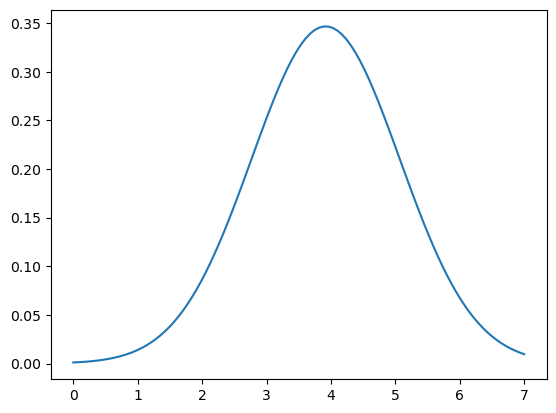

In [134]:
# --------------------------------------------------------------------------
# PART 3

# The formula for L given in lecture 5 "MLE applied to a homoscedastic Gaussian" 
# does not match the way that L was used in the code in that same notebook
# In order to do this numerical method, L needs to be some distribution or dataset

# from lecture 5 
stdev = np.std(justdata)
Gaussian3 = scipy.stats.norm(meanA, stdev)
G3PDF = Gaussian3.pdf(xgrid)
# print(G3PDF)
plt.plot(xgrid, G3PDF)
sigma_mu = np.diff(np.log(G3PDF), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]
print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

In [151]:
# --------------------------------------------------------------------------
# PART 4

# it was not specified how many samples to draw per iteration
print(len(justdata))
N = 1000 # number of iteration
S = 100 # how many samples per iteration

#def boots(N):
#    bootstrap = []
#    for hh in range(N):
#        for j in range(S):
#            index = np.random.randint(0, len(justdata))
#            bootstrap.append(justdata[index])
#    return(bootstrap)

#a = boots(N)
#print(np.shape(a))
#the above had several edits and still wasnt working and I couldnt figure out why. 
# went to gemini AI, but not sure how to cite other than here

bootstrap = []
for i in range(N):
    realize = np.random.choice(justdata, size = len(justdata), replace = True)
    bootstrap.append(realize)
    # not sure why we need the uncertainties here? Could do uncertainties separately and avoid errors that happened when I tried to do this together. 

print(np.shape(bootstrap))
# plt.hist(justdataboots, bins = 50, density = True)
# print(len(justdataboots))

100
(1000, 100)


Text(0.5, 1.0, 'Bootstrap histogram approximation vs Model Gaussian')

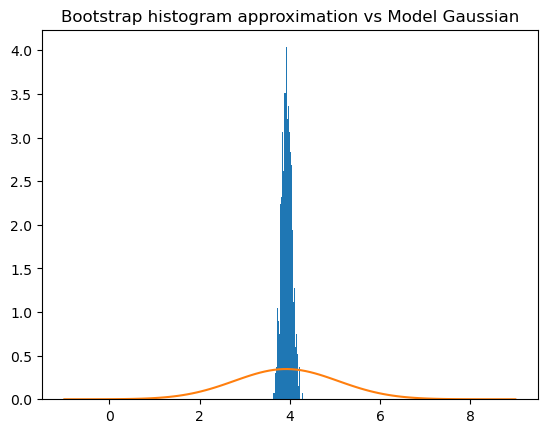

In [139]:
# --------------------------------------------------------------------------
# PART 5
"""
c = np.array(justdataboots)
d = np.array(justuncertboots)
newxgrid = np.linspace(-6, 7, 100)
avgData_boots = np.mean(a)
generated = lambda mu: - LnLikelihood(mu, c, d)
GaussianGen2 = scipy.optimize.minimize(generated, avgData_boots)
fitb = GaussianGen2.x[0]
print(fitb)
# plots
Model_Gauss = scipy.stats.norm(fitb, stdev)
Model_PDF = Model_Gauss.pdf(newxgrid)
plt.plot(newxgrid, Model_PDF)
"""
#above was not working. left it in. 
bData = np.array(bootstrap)
averages = []
for i in range(N):
    averages.append(bData[i].mean())

pt5xgrid = np.linspace(-1, 9, 100)
Gaaa = scipy.stats.norm.pdf(pt5xgrid, meanA, stdev)
plt.hist(averages, bins = 50, density = True)
plt.plot(pt5xgrid, Gaaa)
# well thats a bit different
plt.title('Bootstrap histogram approximation vs Model Gaussian')

In [140]:
# --------------------------------------------------------------------------
# PART 6

# laplace distro has a slightly different scale parameter

def LnL_Laplace(duals, justdata): 
    mu, beta = duals
    LnL = - np.sum(np.log(2 * beta) + np.abs(justdata-mu) / beta)
    return(LnL)


generated = lambda duals: - LnL_Laplace(duals, justdata)
l = scipy.optimize.minimize(generated, [np.mean(justdata), stdev])
fitmu = l.x[0]
fitbeta = l.x[1]
print(fitmu, fitbeta)
# tried to pass two args to the lambda function but couldn't figure out the syntax
# had to bother classmates to get this: Thanks Anthony and Joel

4.085951746169762 0.882269246180275


In [141]:
# --------------------------------------------------------------------------
# PART 7
kg = 1
kl = 2
LLL = [fitmu, fitbeta]
print(type(LLL))
LLLL = np.array(LLL)

# from lecture 6
AIC_Gaussian = -2 * LnLikelihood(justdata, justuncert, fit) + 2*kg + ((2*kg*(kg + 1))/(N - kg - 1))
AIC_Laplacian = -2 * LnL_Laplace(LLL, justdata) + 2*kl + ((2*kl*(kl + 1))/(100 - kl - 1))

print(AIC_Gaussian, AIC_Laplacian) 
# What the heck? Alright I've checked both likelihood functions and can't find anything wrong
# but there's gotta be something going sideways. 


<class 'list'>
956.1113783739572 317.7015436933864


In [148]:
# --------------------------------------------------------------------------
# PART 8

import corner

generated = lambda duals: - LnL_Laplace(duals, bootstrap)
l = scipy.optimize.minimize(generated, [np.mean(bootstrap), stdev])
fitmu = l.x[0]
fitbeta = l.x[1]
print(fitmu, fitbeta) # well the optimized bootstrap is close, but I need something to PLOT. 
# Out of time. 

#corner.corner()

3.9351385311345277 1.1507206049948653


In [150]:
# --------------------------------------------------------------------------
# PART 9

H = nd.Hessian(LnL_Laplace)([l.x[0], l.x[1]]) # huh that's weird. It's not working
sigma_laplace = np.linalg.inv(H)**0.5

TypeError: LnL_Laplace() missing 1 required positional argument: 'justdata'